This project aims to analyze a large set of hospital data to identify features that impact diabetic readmission and predict whether patients should be recommended to readmit. The underlying business goal for the client (a hospital doing diabetic treatment and readmission care) is to improve care by using the model to supplement doctors’ decisions and therefore increase profit. Based on a cost matrix built from U.S. hospital averages, models can potentially increase the client’s profits by over a hundred million dollars a year. 

##Setting Up

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import uniform, randint

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm ## Generate coefficient statistics for logistic regression
from sklearn.svm import LinearSVC, SVC
 
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix # accuracy and confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report # precision, recall, and f1
from sklearn.metrics import plot_roc_curve, roc_auc_score # roc and auc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## EDA and Data Prep

In [ ]:
# Read the .csv file and store it as a pandas DataFrame
db = pd.read_csv("diabetic_data.csv")

# Get the shape
print("Data shape (rows, cols):")
print(db.shape)

# Get the column types
print("\nFeature types:")
print(db.dtypes)

# Get the missing values
print("\nMissing info:")
print(db.isna().sum())

# View the data
db.head()

In [ ]:
print(db.readmitted.value_counts()/db.readmitted.count())
sns.countplot(db.readmitted)

In [ ]:
#db['diag_1'] = db.diag_1.replace({'?': None})
#db['diag_2'] = db.diag_2.replace({'?': None})
#db['diag_3'] = db.diag_3.replace({'?': None})

#db.head()

In [ ]:

target_name = "readmitted"


X = db.drop(target_name, axis = 1)
X = X.drop("encounter_id", axis = 1)
X = X.drop("patient_nbr", axis = 1)

y = db[target_name]


fnames = list(X.columns)
print(fnames)

findex = X.index

cnames = np.sort(y.unique())
cnames = [str(x) for x in cnames] 

print(cnames)

['Caucasian', 'AfricanAmerican', 'Asian', 'Hispanic', 'Other', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']
['0', '1']


In [ ]:
scaler = StandardScaler()
X_array = scaler.fit_transform(X)
X = pd.DataFrame(X_array, columns = fnames, index = findex)
X.describe()

,Caucasian,AfricanAmerican,Asian,Hispanic,Other,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,...,93295.0,93295.0,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,9.329500e+04,93295.000000,9.329500e+04,9.329500e+04
mean,-1.218574e-18,1.340431e-17,1.035788e-17,-4.508723e-17,-1.584146e-17,-2.802720e-17,-3.168292e-17,9.748590e-17,3.533864e-17,4.386865e-17,...,0.0,0.0,2.376219e-17,1.279502e-17,1.599378e-18,-2.094424e-19,2.894113e-18,0.000000,4.813366e-17,-6.488905e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,0.0,0.0,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005,1.000005e+00,1.000005e+00
min,-1.821377e+00,-4.848440e-01,-8.004810e-02,-1.436403e-01,-1.221701e-01,-9.260751e-01,-3.849467e+00,-6.959781e-01,-5.134565e-01,-1.187037e+00,...,0.0,0.0,-9.699654e-01,-8.325847e-02,-9.260500e-03,-3.273958e-03,-4.630101e-03,-0.003274,-9.275938e-01,-1.830474e+00
25%,5.490352e-01,-4.848440e-01,-8.004810e-02,-1.436403e-01,-1.221701e-01,-9.260751e-01,-6.996649e-01,-6.959781e-01,-5.134565e-01,-1.187037e+00,...,0.0,0.0,-9.699654e-01,-8.325847e-02,-9.260500e-03,-3.273958e-03,-4.630101e-03,-0.003274,-9.275938e-01,5.463067e-01
50%,5.490352e-01,-4.848440e-01,-8.004810e-02,-1.436403e-01,-1.221701e-01,-9.260751e-01,-6.970450e-02,-6.959781e-01,-5.134565e-01,2.903589e-01,...,0.0,0.0,-6.099124e-02,-8.325847e-02,-9.260500e-03,-3.273958e-03,-4.630101e-03,-0.003274,-9.275938e-01,5.463067e-01
75%,5.490352e-01,-4.848440e-01,-8.004810e-02,-1.436403e-01,-1.221701e-01,1.079826e+00,5.602559e-01,6.851271e-01,-1.338139e-01,2.903589e-01,...,0.0,0.0,8.479829e-01,-8.325847e-02,-9.260500e-03,-3.273958e-03,-4.630101e-03,-0.003274,1.078058e+00,5.463067e-01
max,5.490352e-01,2.062519e+00,1.249249e+01,6.961834e+00,8.185308e+00,1.079826e+00,1.820177e+00,4.137890e+00,4.611719e+00,4.722546e+00,...,0.0,0.0,1.756957e+00,1.796693e+01,1.079855e+02,3.054407e+02,2.159780e+02,305.440665,1.078058e+00,5.463067e-01


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 1, 
                                                  stratify = y) 

## Clustering

In [ ]:
scaler = MinMaxScaler()
norm_customer = pd.DataFrame(data = scaler.fit_transform(db), columns = db.columns)
norm_customer.describe()

In [ ]:
sse = [] # Sum of Squared Error of data points to centroid; The smaller the better.
for i in range(1, 20): # get the prefect number of clusters from 1 to 20
    customer_kmeans = KMeans(n_clusters = i, random_state = 42)
    customer_kmeans.fit(norm_customer)
    sse.append(customer_kmeans.inertia_)
    
plt.plot(range(1, 20), sse, marker = 'o')
plt.plot(4, sse[3], color = 'r', marker = 'o') # plot red mark on k = 4
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
customer_kmeans_4 = KMeans(n_clusters = 4, random_state = 42)
customer_kmeans_4.fit(norm_customer)
#customer_kmeans_4.labels_

In [ ]:
norm_customer['cluster'] = customer_kmeans_4.labels_
print(norm_customer['cluster'].value_counts())
norm_customer.describe()

In [ ]:
#gives mean value for each cluster
pd.set_option('display.max_rows', 100)
group = norm_customer.groupby('cluster').mean().T
group

## Random Forest

In [ ]:
#make pipeline for random forest
rf_pp = Pipeline([
        ('scaler', StandardScaler()),
        ('rf_clf', RandomForestClassifier(n_estimators = 100, random_state = 1))])
# Set tuning parameters
parameters = {'rf_clf__max_features':(2, 5, 10),
              'rf_clf__max_depth': (10, 20, 30)}
#Do gridsearch
grid_clf = GridSearchCV(rf_pp, 
                        parameters, 
                        cv = 3, 
                        verbose = 3,
                        scoring = 'accuracy', 
                        return_train_score = True)
grid_clf.fit(X_train, y_train)

# Best Model
print(grid_clf.best_params_) # print best paramters and best score
print(f'CV score: {grid_clf.best_score_}')

# Apply to Test
y_test_grid = grid_clf.predict(X_test) #auto chooses best one
acc_rf_grid = accuracy_score(y_test, y_test_grid)
print(f"The test data performance for the best rf through grid search is: {acc_rf_grid:.2%}")
print(classification_report(y_test, y_test_grid, digits = 4))

In [ ]:
feat_imp = pd.DataFrame(list(zip(X_train.columns, rf_rand_clf.best_estimator_.steps[1][1].feature_importances_)), 
                       columns = ['feature', 'xg_imp_score']).sort_values(by = 'xg_imp_score', ascending = False)
feat_imp

## Log Reg

In [ ]:
# Train
lg_poly = LogisticRegression(random_state = 1, C = 1.0)
lg_poly.fit(X_train_poly, y_train)

# Test
y_pred_lgpoly= lg_poly.predict(X_test_poly)
acc_log_poly = accuracy_score(y_test, y_pred_lgpoly)
print(f"The test data performance for the logistic regression is {acc_log_poly:.2%}")
print(classification_report(y_test, y_pred_lgpoly, digits = 4))

The test data performance for the logistic regression is 62.18%
              precision    recall  f1-score   support

           0     0.6264    0.7399    0.6784     10059
           1     0.6139    0.4837    0.5411      8600

    accuracy                         0.6218     18659
   macro avg     0.6201    0.6118    0.6098     18659
weighted avg     0.6206    0.6218    0.6151     18659



In [ ]:
#from sklearn.pipeline import Pipeline
lg_poly_pp = Pipeline([ ('poly_features', PolynomialFeatures(degree = 2)), 
                        ('logistic_regression', LogisticRegression(random_state = 1, C = 0.15))])

lg_poly_pp.fit(X_train, y_train)
y_test_lgpolypp = lg_poly_pp.predict(X_test)
print(f"The test data performance for logistic regression is {accuracy_score(y_test, y_test_lgpolypp):.2%}")
print(classification_report(y_test, y_test_lgpolypp, digits = 4))

The test data performance for logistic regression is 62.23%
              precision    recall  f1-score   support

           0     0.6239    0.7538    0.6827     10059
           1     0.6193    0.4685    0.5334      8600

    accuracy                         0.6223     18659
   macro avg     0.6216    0.6111    0.6081     18659
weighted avg     0.6218    0.6223    0.6139     18659



number_inpatient     0.465179
number_emergency     0.199201
number_diagnoses     0.156423
diabetesMed          0.131239
number_outpatient    0.103599
time_in_hospital     0.050592
admission_type_id    0.046595
change               0.044120
age                  0.033039
acetohexamide        0.030184
dtype: float64

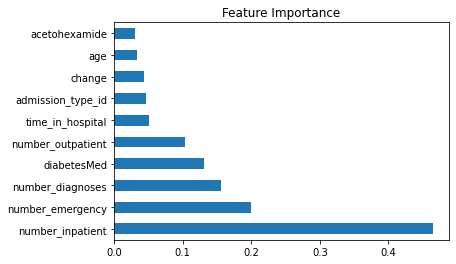

In [ ]:
lg_poly.fit(X,y)
importance = lg_poly.coef_[0]
feature_importances = pd.Series(importance, index = X_test.columns)
feature_importances.nlargest(10).plot(kind='barh', title = 'Feature Importance')
feature_importances.sort_values(ascending = False).nlargest(10)

##KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2, #20% for testing and 80% for training
                                                  random_state = 1, 
                                                  stratify = y)

In [ ]:
# Train
knn = KNeighborsClassifier(n_neighbors = 7, metric='euclidean') # 'manhattan'/ 'euclidean'
knn.fit(X_train, y_train)

# Test
y_test_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_test_knn)
print(f"The test data performance for the K-nearest neighbor is {acc_knn:.2%}")
print(classification_report(y_test, y_test_knn, digits = 4))

## SVM

In [ ]:
rbf_svm_clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm_clf', SVC(kernel = 'rbf',
                        random_state = 1, gamma = 0.01))])

parameters = {'svm_clf__C': (1, 2, 3)}

grid_clf = GridSearchCV(rbf_svm_clf, 
                        parameters, 
                        cv = 3, 
                        verbose = 3,
                        scoring = 'accuracy', 
                        return_train_score = True)
grid_clf.fit(X_train, y_train)

In [ ]:

print(grid_clf.best_params_) # best paramters
print(f'CV score: {grid_clf.best_score_}')

y_test_grid = grid_clf.predict(X_test)
acc_rbf_svm_grid = accuracy_score(y_test, y_test_grid)
print(f"The test data performance for the best rbf svm through grid search is: {acc_rbf_svm_grid:.2%}")
print(classification_report(y_test, y_test_grid, digits = 4))

## XGBOOST

In [ ]:
xg = Pipeline([('scaler', StandardScaler()), 
                ('poly_features', PolynomialFeatures()),
                ('fselection', SelectKBest(mutual_info_classif)),
                ('xgboost',XGBClassifier(n_estimators = 100, random_state = 1))])

parameters = {'poly_features__degree':randint(1,3),
              'fselection__k':randint(10,20),
              'xgboost__max_depth':randint(3,10),
              'xgboost__min_child_weight':randint(1,10),
              'xgboost__gamma': uniform(0,1),
              'xgboost__learning_rate': uniform(0.05,0.25),
              'xgboost__subsample': uniform(0.5,0.4 ),
              'xgboost__colsample_bytree':uniform(0.5, 0.4)}


# Use the n_iter to control the number of paramter combinations.
rand_clf = RandomizedSearchCV(xg, 
                              parameters, 
                              n_iter = 10, 
                              random_state = 1, 
                              cv = 3, 
                              verbose = 3,
                              scoring = 'accuracy', 
                              return_train_score = True)
rand_clf.fit(X_train, y_train)

In [ ]:
print(rand_clf.best_params_) # best paramters
print(f'CV score: {rand_clf.best_score_}')

# Test
y_test_rdCV = rand_clf.predict(X_test)
acc_rbf_svm_rd = accuracy_score(y_test, y_test_rdCV)
print(f"The test data performance for the best rbf svm through randomized search is: {acc_rbf_svm_rd:.2%}")
print(classification_report(y_test, y_test_rdCV, digits = 4))

 Using this XGBOOST, I was able to achieve the highest accuracy among the other classifiers at 66.63%. To achieve this accuracy, we used RandomSearch to find the best parameters of max_depth, min_child_weight, and gamma. 


## Cost Matrix Assumptions

The cost matrix is from the perspective of the Hospital client. These figures are in dollars and represent hospital gains or losses per patient per year under the model we developed, relative to prior operations. These figures do not include the flat costs of implementing and developing the model (assume negligible figures). 

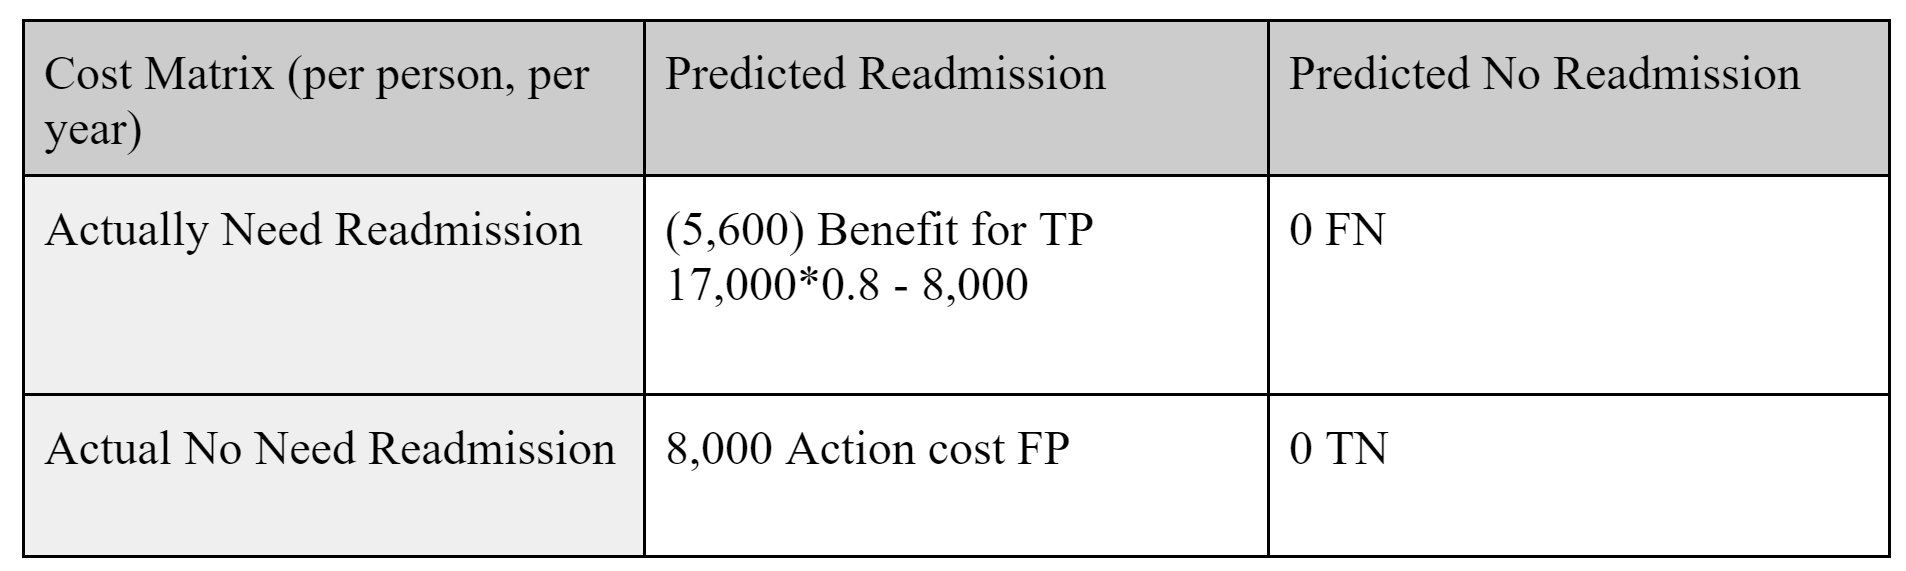

True positives: Our model predicts readmission and the patient does need readmission. The action cost is for additional readmission programs to help the patient. The benefit is the revenue gained by the hospital for correct care, and the success rate is based on the outcome of patient health. Assuming 17,000 revenue gain and 80% success rate since the failure rate of diabetes care is around 20%. 

False positives: Our model predicted readmission when no readmission is needed. The cost here is the action cost for the hospital to treat the patient unnecessarily. Assume \$1000 for a medical weight loss program and $8,000 for an additional 4 days of in-patient care.

True negatives: Our model predicts no readmission and the patient does not need readmission. The net cost is 0 since the model does not prompt the doctor to re-evaluate the patient.

False negatives: Our model predicts no readmission is needed when the patient actually does need readmission. The net cost is 0 since the model does not prompt the doctor to re-evaluate the patient.


## Recommendation

This model be used in conjunction with doctors’ decisions as a supplementary second opinion. Medical professionals can evaluate the patient based on complex qualitative aspects not captured by this model, but if a patient is flagged for readmission by the model, the doctor should consider the model’s input in their judgment. For those who are recommended for diabetic readmission,  the hospital will allocate resources for diet and fitness programs, extra physician/nurse visits, administrative tasks, and medicine/supplies. For those who are not recommended, there is no net gain or loss for the hospital; patient care ends.